In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive
import os
os.chdir('drive/Colab Notebooks')
print(os.getcwd())

E: Package 'python-software-properties' has no installation candidate

··········
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
 CNN.ipynb  'Colab Notebooks'   delta.ipynb  'dif&surf.ipynb'
/content/drive/Colab Notebooks


In [0]:
import torch

import torch.nn.functional as F
import torch.nn as nn
import numpy as np

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import optim
from torch.autograd import Variable

import matplotlib.pyplot as plt

CLASS_NUM = 5

In [0]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, (1, 16), stride = (1, 8))
        self.conv2 = nn.Conv2d(6, 16, (14, 11), stride = (10, 5))
        self.conv3 = nn.Conv2d(16, 32, (2, 3), stride = 2)
        self.fc1 = nn.Linear(32*5*4, 200)
        self.fc2 = nn.Linear(200, 40)
        self.fc3 = nn.Linear(40, CLASS_NUM)
 
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (4,1))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = nn.Softmax(x)
        return x

In [4]:
if __name__ == '__main__':
    plt.ion()
    if_cuda = True # torch.cuda.is_available()

    transform = transforms.Compose([
        # transforms.Resize(),
        transforms.ToTensor(),      # 转换为Tensor&归一化至[0,1]
        transforms.Normalize(mean = [.5,.5,.5], std = [.5,.5,.5]) # 标准化至[-1,1]
    ])

    train_dataset = ImageFolder('data3/train/', transform = transform)
    val_dataset = ImageFolder('data3/val/', transform = transform)
    test_dataset = ImageFolder('data3/test/', transform = transform) + val_dataset
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4)
    print(train_dataset.class_to_idx)

{'Agent': 0, 'Dofloo': 1, 'Lady': 2, 'Mayday': 3, 'normal': 4}


In [10]:
    model = CNN_Model()

    epo = 50
  
    if if_cuda: 
        model.cuda()
        loss_function = nn.CrossEntropyLoss().cuda()
    else:
        loss_function = nn.CrossEntropyLoss()
        
    lr = 5e-5
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))
    train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = [], [], [], []

    # model.apply(weight_init)

    for epoch in range(epo):
        train_loss, valid_loss = [], []
        train_acc, valid_acc = [], []

        model.train()
        for data, target in train_loader:
            if if_cuda: 
                data = data.cuda()
                target = target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            pre = output.argmax(dim=1)
            train_acc.append(pre.item() == target.item())

        model.eval()
        for data, target in val_loader:
            if if_cuda: 
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            # output = output.max(1)[1].float()
            loss = loss_function(output, target)
            valid_loss.append(loss.item())
            pre = output.argmax(dim=1)
            valid_acc.append(pre.item() == target.item())
        print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss), "Valid Loss: ", np.mean(valid_loss), "Train Accuracy: ", np.mean(train_acc), "Valid Accuracy: ", np.mean(valid_acc))
        train_loss_list.append(np.mean(train_loss))
        valid_loss_list.append(np.mean(valid_loss))
        train_acc_list.append(np.mean(train_acc))
        valid_acc_list.append(np.mean(valid_acc))
        
        if epoch > 30 and np.mean(valid_acc) > 0.7:
            break
        
        if epoch >= 20 and epoch % 10 == 0:
            lr /= 2
            print("lr/=2, lr= ", lr)
            ptimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99))
                


Epoch: 0 Training Loss:  1.6391792169639043 Valid Loss:  1.6342311880805276 Train Accuracy:  0.10714285714285714 Valid Accuracy:  0.09090909090909091
Epoch: 1 Training Loss:  1.6261374652385712 Valid Loss:  1.6209631020372564 Train Accuracy:  0.10714285714285714 Valid Accuracy:  0.045454545454545456
Epoch: 2 Training Loss:  1.6106707113129752 Valid Loss:  1.5894406871362166 Train Accuracy:  0.10714285714285714 Valid Accuracy:  0.09090909090909091
Epoch: 3 Training Loss:  1.5733622738293238 Valid Loss:  1.5366154584017666 Train Accuracy:  0.32142857142857145 Valid Accuracy:  0.6363636363636364
Epoch: 4 Training Loss:  1.5029539465904236 Valid Loss:  1.4166608290238814 Train Accuracy:  0.5714285714285714 Valid Accuracy:  0.6363636363636364
Epoch: 5 Training Loss:  1.413589439221791 Valid Loss:  1.2700719779187983 Train Accuracy:  0.5714285714285714 Valid Accuracy:  0.6363636363636364
Epoch: 6 Training Loss:  1.3297553530761175 Valid Loss:  1.2160544828935103 Train Accuracy:  0.5714285714

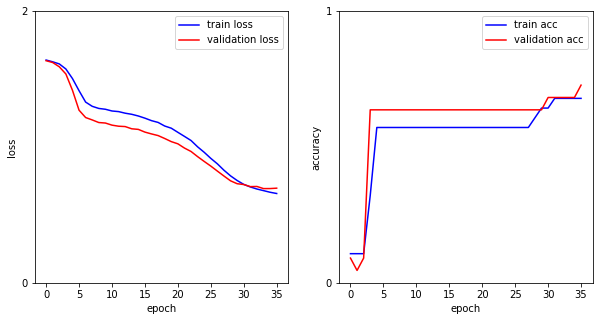

2 2 True
4 4 True
3 1 False
4 4 True
4 4 True
4 4 True
4 4 True
4 4 True
4 4 True
4 4 True
4 0 False
4 4 True
4 4 True
4 4 True
4 4 True
4 4 True
4 2 False
4 4 True
2 1 False
4 3 False
4 0 False
3 3 True
0.7272727272727273


In [13]:
x = range(epoch+1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
l1, = plt.plot(x, train_loss_list, '-b')
l2, = plt.plot(x, valid_loss_list, '-r')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend([l1, l2], ['train loss', 'validation loss'], loc='best')
plt.yticks([0, 2])


plt.subplot(1, 2, 2)
l1, = plt.plot(x, train_acc_list, '-b')
l2, = plt.plot(x, valid_acc_list, '-r')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([l1, l2], ['train acc', 'validation acc'], loc='best')
plt.yticks([0, 1])

plt.show()

accuracy = []
for data, target in val_loader:
    if if_cuda: 
        data = data.cuda()
        target = target.cuda()
    output = model(data.float())
    pre = output.argmax(dim=1)
    print(pre.item(), target.item(), pre.item() == target.item())
    accuracy.append(pre.item() == target.item())
print(np.mean(accuracy))
